In [1]:
# Da fare: usare allocazioni dinamiche parziali e non 100%; mettere fattori variabili in base al portafoglio; provare a imporre rendimento alto per evitare rendimenti bassi; 

# Importazione librerie

In [2]:
import pandas as pd
import itertools
import matplotlib.pyplot as plt
import ccxt
import time
from math import isclose
import Metriche_di_performance as mdp
from datetime import datetime
import numpy as np
import seaborn as sns
from sklearn.model_selection import ParameterGrid

# Function

In [3]:
def calcola_rendimento_portafoglio_ideale_multicrypto(lista_colonne_prezzi, capitale_iniziale, lista_token_iniziali, min_acquisto=0, min_vendita=0, perc_commissione_acquisto=0, perc_commissione_vendita=0):
    # lista_colonne_prezzi è una lista di pd.Series dei prezzi di ciascuna delle N crypto
    # Supponiamo: N = len(lista_colonne_prezzi)
    # Tutte le serie hanno la stessa lunghezza
    # i-esimo giorno: lista_colonne_prezzi[j][i] è il prezzo della j-esima crypto
    N = len(lista_colonne_prezzi)
    n = len(lista_colonne_prezzi[0])
    
    # Converto i prezzi in una matrice per comodità
    prezzi = []
    for i in range(n):
        prezzi_giorno = [lista_colonne_prezzi[j].iloc[i] for j in range(N)]
        prezzi.append(prezzi_giorno)

    # dp[i][0]: max capitale in USD se a fine giorno i non detengo crypto
    # dp[i][j]: max numero di token della j-esima crypto se a fine giorno i detengo crypto j (j = 1,...,N)
    # Nota: l'indice 0 in dp si riferisce allo stato "nessuna crypto"
    dp = [[float('-inf')] * (N+1) for _ in range(n)]

    # Stato iniziale
    dp[0][0] = capitale_iniziale
    for j in range(1, N+1):
        dp[0][j] = lista_token_iniziali[j-1]  # numero di token iniziali della j-esima crypto

    # Valore iniziale del portafoglio
    valore_iniziale = capitale_iniziale
    for j in range(N):
        valore_iniziale += lista_token_iniziali[j] * prezzi[0][j]

    for i in range(1, n):
        for stato_precedente in range(N+1):
            if dp[i-1][stato_precedente] == float('-inf'):
                continue
            
            # Caso 1: mantengo lo stesso stato (nessuna operazione)
            if stato_precedente == 0:
                # Nessuna crypto ieri, nessuna oggi
                dp[i][0] = max(dp[i][0], dp[i-1][0])
            else:
                # Avevo la crypto stato_precedente
                dp[i][stato_precedente] = max(dp[i][stato_precedente], dp[i-1][stato_precedente])

            # Caso 2: se ero senza crypto ieri, posso comprare crypto k oggi
            if stato_precedente == 0:
                # ho capitale in USD = dp[i-1][0]
                capitale = dp[i-1][0]
                for k in range(1, N+1):
                    if capitale >= min_acquisto:
                        # Compro crypto k
                        bitcoin_acquistati = (capitale * (1 - perc_commissione_acquisto)) / prezzi[i][k-1]
                        if bitcoin_acquistati * prezzi[i][k-1] >= min_acquisto:
                            dp[i][k] = max(dp[i][k], bitcoin_acquistati)

            # Caso 3: se avevo la crypto j ieri, posso vendere oggi e andare in USD
            if stato_precedente > 0:
                # stato_precedente è una crypto j-esima
                j_crypto = stato_precedente
                quantita = dp[i-1][j_crypto]  # numero di token
                valore_vendita = quantita * prezzi[i][j_crypto-1]
                if valore_vendita >= min_vendita:
                    capitale_dopo_vendita = valore_vendita * (1 - perc_commissione_vendita)
                    dp[i][0] = max(dp[i][0], capitale_dopo_vendita)

                # Caso 4: se avevo la crypto j, posso vendere e comprare un'altra crypto k
                for k in range(1, N+1):
                    if k != j_crypto:
                        # Vendo j
                        if valore_vendita >= min_vendita:
                            capitale_intermedio = valore_vendita * (1 - perc_commissione_vendita)
                            # Compro k
                            if capitale_intermedio >= min_acquisto:
                                bitcoin_acquistati = (capitale_intermedio * (1 - perc_commissione_acquisto)) / prezzi[i][k-1]
                                if bitcoin_acquistati * prezzi[i][k-1] >= min_acquisto:
                                    dp[i][k] = max(dp[i][k], bitcoin_acquistati)

    # Calcolo del valore finale
    valore_finale = dp[n-1][0]
    for j in range(1, N+1):
        if dp[n-1][j] != float('-inf'):
            # Vendo l'ultima crypto
            valore_uscita = dp[n-1][j] * prezzi[-1][j-1] * (1 - perc_commissione_vendita)
            valore_finale = max(valore_finale, valore_uscita)

    rendimento = valore_finale / valore_iniziale
    return [rendimento, valore_finale]

In [4]:
def download_and_plot(cryptos, market, timeframe_download, start_date, end_date, plot):
    
    # exchange = ccxt.binance()  # Usa Binance come exchange
    exchange_class = getattr(ccxt, market)  # Ottieni la classe dell'exchange
    exchange = exchange_class()  # Crea un'istanza dell'exchange
    exchange.load_markets()  # Carica i mercati disponibili
    cryptos_pairs = [f"{crypto}/USDT" for crypto in cryptos]  # Adatta i simboli per Binance

    # Converti date in timestamp
    start_timestamp = int(pd.Timestamp(start_date).timestamp() * 1000)
    end_timestamp = int(pd.Timestamp(end_date).timestamp() * 1000)

    data_frames = {}

    for pair in cryptos_pairs:
        if pair not in exchange.markets:
            raise ValueError(f"Il mercato {pair} non è disponibile su Binance.")

        print(f"Scarico i dati per {pair} dal {start_date} al {end_date}...")
        
        ohlcv = []
        since = start_timestamp

        # Scarica i dati in blocchi fino a raggiungere la data di fine
        while since < end_timestamp:
            batch = exchange.fetch_ohlcv(pair, timeframe_download, since)
            if not batch:
                break
            ohlcv.extend(batch)
            since = batch[-1][0] + 1  # Avanza al prossimo blocco
            time.sleep(exchange.rateLimit / 1000)  # Rispetta il rate limit dell'API

        # Crea un DataFrame dai dati
        df = pd.DataFrame(ohlcv, columns=['timestamp', 'open', 'high', 'low', 'close', 'volume'])
        df['timestamp'] = pd.to_datetime(df['timestamp'], unit='ms')
        df.set_index('timestamp', inplace=True)

        # Filtra i dati oltre la data di fine
        df = df[df.index <= pd.Timestamp(end_date)]
        data_frames[pair] = df

        if plot:
            # Plot dei dati
            plt.figure(figsize=(14, 8))

            # Grafico della prima crypto
            plt.subplot(3, 1, 1)
            plt.plot(data_frames[pair].index, data_frames[pair]['close'], label=f"{pair} Price")
            plt.title(f"{pair} Price")
            plt.ylabel('Price (USDT)')
            plt.grid()
            # plt.legend()

            plt.tight_layout()
            plt.show()

    return {k.replace('/USDT', ''): v for k, v in data_frames.items()}

In [5]:
def calcola_fattori_di_variazione(crypto_prices):
    """
    Calcola i fattori di variazione dei prezzi giornalieri per ogni crypto e aggiunge una colonna
    con il prodotto dei fattori di variazione giornalieri.
    
    Parametri:
    - crypto_prices: DataFrame con i prezzi giornalieri di ogni crypto (righe=giorni, colonne=crypto).
    
    Ritorna:
    - df_fattori: DataFrame con i fattori di variazione e una colonna aggiuntiva per il prodotto dei fattori.
    - metriche: Serie con le medie delle colonne.
    """
    # Calcola i fattori di variazione (rapporto tra il prezzo corrente e quello del giorno precedente)
    fattori_variazione = crypto_prices / crypto_prices.shift(1)
    
    # Aggiungi una colonna per il prodotto dei fattori di variazione giornalieri
    fattori_variazione['prodotto_fattori'] = fattori_variazione.prod(axis=1)
    
    # Calcola metriche numeriche (ad esempio le medie)
    metriche = fattori_variazione.mean()
    
    return fattori_variazione, metriche

In [6]:
# Funzione per identificare massimi e minimi locali
def trova_massimi_minimi_locali(series):
    massimi = series[(series.shift(1) < series) & (series.shift(-1) < series)]
    minimi = series[(series.shift(1) > series) & (series.shift(-1) > series)]
    return massimi, minimi

In [7]:
def generate_allocations(cryptos, precision):
    """
    Genera tutte le possibili combinazioni di asset allocation per un numero di crypto specificato.

    Parametri:
    - cryptos: Lista delle crypto selezionate.
    - precision: Precisione delle allocazioni (0 significa interi, 1 significa 1 decimale, etc.).

    Ritorna:
    - Lista di dizionari con le possibili allocazioni.
    """
    step = 10 ** -precision  # Es. precision=1 -> step=0.1
    # num_steps = int(1 / step) + 1

    # Genera tutte le combinazioni di allocazioni
    ranges = [np.arange(0, 1 + step, step) for _ in cryptos]
    all_combinations = [combo for combo in itertools.product(*ranges) if isclose(sum(combo), 1, abs_tol=1e-9)]

    # Converti in dizionario con i nomi delle crypto
    allocations = [dict(zip(cryptos, combo)) for combo in all_combinations]
    return allocations

In [8]:
def map_variation_to_liquidity_on_fall(variation, factor_fall, perc_liquidita_attuale):
    """
    Mappa la variazione percentuale della media mobile del portafoglio totale a una percentuale di liquidità desiderata.

    Parametri:
    - variation: Variazione percentuale rispetto al massimo locale.

    Ritorna:
    - Percentuale di liquidità.
    """
    return max(0, min(1, perc_liquidita_attuale + variation * factor_fall))

In [9]:
def map_variation_to_liquidity_on_rise(variation, factor_rise, perc_liquidita_attuale):
    """
    Mappa la variazione percentuale della media mobile del portafoglio totale a una percentuale di liquidità desiderata.

    Parametri:
    - variation: Variazione percentuale rispetto al minimo locale.

    Ritorna:
    - Percentuale di liquidità.
    """
    return max(0, min(1, perc_liquidita_attuale - variation * factor_rise))

In [10]:
def map_return_to_factor_fall(current_return, factor_fall, perc_factor_fall, desired_return, risk):
    return factor_fall * (1 - perc_factor_fall) if current_return < desired_return else factor_fall if risk else np.inf

In [11]:
def map_return_to_factor_rise(current_return, factor_rise, perc_factor_rise, desired_return, risk):
    return factor_rise * (1 + perc_factor_rise) if current_return < desired_return else factor_rise if risk else -np.inf

## Strategia di ribilanciamento dinamica

In [12]:
def simulate_rebalancing_strategy_dynamical(dati, initial_allocations, dynamical_timeframe, statical_timeframe, initial_portfolio_value, window_allocations, precision, window_portfolio, verbose, factor_fall, factor_rise, dynamical_factors, perc_factor_fall, perc_factor_rise, desired_return, weighting_factor, risk):
    """
    Simula una strategia di ribilanciamento dinamico del portafoglio di crypto con aggiornamento delle allocazioni iniziali
    ogni `dynamical_timeframe` giorni, utilizzando la migliore allocazione per i precedenti `window` giorni.

    Parametri:
    - dati: DataFrame con i prezzi delle crypto (righe=giorni, colonne=symbol), con un timestamp come indice
    - initial_allocations: Dizionario con le percentuali di allocazione iniziale per ogni crypto
    - dynamical_timeframe: Numero di giorni tra un ribilanciamento e l'altro nella strategia dinamica
    - statical_timeframe: Numero di giorni tra un ribilanciamento e l'altro nella strategia che viene chiamata per simulare sul passato (utile solo se window_allocations non è None)
    - initial_portfolio_value: Valore iniziale del portafoglio in USD
    - window_allocations: Numero di giorni utilizzati come finestra mobile per calcolare la migliore allocazione precedente
    - precision: Precisione delle allocazioni (es. 1 per step di 0.1, 2 per step di 0.01 ecc)
    - window_portfolio: Numero di giorni utilizzati come finestra mobile per monitorare l'andamento del portafoglio e quindi decidere quanto tenere in liquidità
    - verbose: Booleano che decide quanti print mostrare durante l'esecuzione
    - factor_fall: Fattore che decide, tramite la function map_variation_to_liquidity_on_fall, quanta liquidità avere nel caso il portafoglio scenda (più è alto e più voglio avere 100% liquidità)
    - factor_rise: Fattore che decide, tramite la function map_variation_to_liquidity_on_rise, quanta liquidità avere nel caso il portafoglio salga (più è alto e più voglio avere 0% in liquidità)
    - dynamical_factors: Booleano che decide se cambiare dinamicamente factor_rise e factor_fall
    - perc_factor_fall: Percentuale usata nella function map_return_to_factor_fall per decidere quanto calare factor_fall se se sono lontano dal mio obiettivo di guadagno
    - perc_factor_rise: Percentuale usata nella function map_return_to_factor_rise per decidere quanto aumentare factor_rise se sono lontano dal mio obiettivo di guadagno
    - desired_return: Obiettivo di guadagno in termini di fattore di rendimento (rapporto tra portafoglio finale e portafoglio iniziale)
    - weighting_factor: Percentuale di "sfumatura" per decidere quanto ruotare sulla migliore allocazione trovata col backtesting (100% significa che ruoto tutto sulla crypto considerata a posteriori la migliore secondo il backtesting; 0% significa che uso come allocazioni esattamente le percentuali che rappresentano i punteggi delle crypto più performanti secondo il backtesting); utile solo se window_allocations non è None (cioè se il backtesting viene fatto); attenzione: si può usare solo se precision = 0
    - risk: Booleano che decide se rischiare o no: se è True ci sono potenziali rendimenti più alti ma anche potenziali perdite più alte, mentre se è False si pone la liquidità desiderata al 100% non appena viene raggiunto o superato il guadagno desiderato (cioè si vende tutto); utile solo se dynamical_factors è True

    Ritorna:
    - DataFrame con timestamp, prezzi, quantità di token, controvalori e valore totale del portafoglio.
    """
    # Verifica che le allocazioni iniziali sommino a 1
    assert isclose(sum(initial_allocations.values()), 1, abs_tol=1e-9), "Le allocazioni iniziali devono sommare a 1."

    # Inizializza le quantità iniziali di ciascuna crypto
    prezzi_iniziali = dati.iloc[0]
    quantita_token = {crypto: (initial_portfolio_value * initial_allocations[crypto]) / prezzi_iniziali[crypto] for crypto in dati.columns}
    # print('quantità token:', quantita_token)

    # Lista per salvare i risultati
    risultati = []

    # Genera tutte le possibili allocazioni
    allocations = generate_allocations(list(dati.columns), precision)
    
    liquidita = 0

    columns = list(dati.columns)

    # Simulazione giorno per giorno
    for i, row in enumerate(dati.itertuples()):
        # row è un namedtuple => row[0] = index, row[1] = primo valore, ecc.
        timestamp = row[0]   # se l'indice del DataFrame è il timestamp
        prezzi = {columns[idx]: row[idx+1] for idx in range(len(columns))}    # tutti i prezzi

        # Calcola il valore totale attuale del portafoglio
        controvalori = {crypto: quantita_token[crypto] * prezzi[crypto] for crypto in dati.columns}
        valore_totale_portafoglio = sum(controvalori.values()) + liquidita

        # Ribilanciamento ogni `dynamical_timeframe` giorni
        if i > 0 and i % dynamical_timeframe == 0:
            if window_allocations is not None:
                # Definisci il periodo precedente `window_allocations` giorni per calcolare la miglior allocazione
                start_window = max(0, i - window_allocations)
                dati_window = dati.iloc[start_window:i]

                # Trova la migliore allocazione per il periodo precedente
                best_allocation = None
                best_return = -np.inf
                rendimenti_temp = {}

                for index, allocation in enumerate(allocations):
                    risultati_df_temp = simulate_rebalancing_strategy_dynamical(dati_window, allocation, statical_timeframe, statical_timeframe, initial_portfolio_value, None, precision, window_portfolio, False, factor_fall, factor_rise, dynamical_factors, perc_factor_fall, perc_factor_rise, desired_return, weighting_factor, risk) # Per simulare sul passato devo passare come fattore dinamico quello statico, altrimenti non cambierebbe niente dato che statical_timeframe non viene usato da nessuna parte
                    rendimento_temp = risultati_df_temp['valore_totale_portafoglio'].iloc[-1] / risultati_df_temp['valore_totale_portafoglio'].iloc[0]
                    if precision == 0:
                        crypto_max = dati.columns[len(dati.columns) - index - 1] # Cerco la crypto che è appena stata testata (con precision = 0 ho solo una crypto con allocazione 1 e tutte le altre 0)
                        rendimenti_temp[crypto_max] = rendimento_temp
                    if rendimento_temp > best_return:
                        best_return = rendimento_temp
                        best_allocation = allocation

                    if verbose:
                        print(f"Miglior allocazione trovata per il giorno {timestamp}: {best_allocation}")

                # Aggiorna le allocazioni iniziali in base a weighting_factor
                if precision == 0:
                    scores = {}
                    weighted_averages = {}
                    somma = sum(rendimenti_temp.values())
                    for crypto in dati.columns:
                        scores[crypto] = rendimenti_temp[crypto] / somma
                        weighted_averages[crypto] = scores[crypto] * (1 - weighting_factor) + best_allocation[crypto] * weighting_factor # Se weighting_factor = 0, verranno assegnate come nuove allocazioni esattamente le percentuali ottenute dai punteggi, che rappresentano in percentuale chi ha performato meglio in passato, mentre se weighting_factor = 1 le nuove allocazioni saranno le best_allocation, che con precision = 0 equivale a dire che sono tutte 0% tranne la crypto che ha performato meglio nel passato (che è 100%)
                    best_allocation = weighted_averages

                initial_allocations = best_allocation

            if dynamical_factors:
                current_return = pd.DataFrame(risultati)['valore_totale_portafoglio'].iloc[-1] / pd.DataFrame(risultati)['valore_totale_portafoglio'].iloc[0]
                factor_fall = map_return_to_factor_fall(current_return, factor_fall, perc_factor_fall, desired_return, risk)
                factor_rise = map_return_to_factor_rise(current_return, factor_rise, perc_factor_rise, desired_return, risk)

            # Calcola i valori target per ciascuna crypto
            valori_target = {crypto: (valore_totale_portafoglio - liquidita) * initial_allocations[crypto] for crypto in dati.columns}

            for crypto in dati.columns:
                # Vendere crypto sopra il target
                if controvalori[crypto] > valori_target[crypto]:
                    eccedenza = controvalori[crypto] - valori_target[crypto]
                    quantita_token[crypto] -= eccedenza / prezzi[crypto]

                # Comprare crypto sotto il target
                elif controvalori[crypto] < valori_target[crypto]:
                    deficit = valori_target[crypto] - controvalori[crypto]
                    quantita_token[crypto] += deficit / prezzi[crypto]


            # Calcola la media mobile del portafoglio se ci sono abbastanza dati
            if window_portfolio is not None and i >= window_portfolio:
                portfolio_series = pd.Series([r['valore_totale_portafoglio'] for r in risultati])
                media_mobile = portfolio_series.rolling(window=window_portfolio).mean()

                # Identifica massimi e minimi locali della media mobile
                massimi_locali, minimi_locali = trova_massimi_minimi_locali(media_mobile[:i+1])

                ultimo_massimo = massimi_locali.iloc[-1] if not massimi_locali.empty else None
                ultimo_minimo = minimi_locali.iloc[-1] if not minimi_locali.empty else None


                # Calcoliamo la media mobile attuale
                # i corrisponde all'indice "posizionale" nel DataFrame dei risultati
                # Assicuriamoci che i sia un indice valido in media_mobile
                # (dovrebbe esserlo, poiché i >= window_portfolio)
                current_ma = media_mobile.iloc[-1]

                # Verifichiamo qual è il pivot più recente
                # (se l'ultimo massimo è più recente dell'ultimo minimo, o se il minimo non esiste)
                if ultimo_massimo is not None and (ultimo_minimo is None or massimi_locali.index[-1] > minimi_locali.index[-1]):
                    # Caso: pivot più recente è un massimo locale
                    # Calcoliamo la variazione percentuale dal massimo alla media attuale
                    variation = (ultimo_massimo - current_ma) / ultimo_massimo

                    # Se effettivamente dobbiamo AUMENTARE la liquidità (ad es. vendendo)
                    # confrontiamo la percentuale di liquidità già presente con la "perc_liquidita_desiderata" desiderata
                    perc_liquidita_attuale = liquidita / valore_totale_portafoglio

                    # Mappiamo questa variazione in una percentuale di liquidità desiderata
                    perc_liquidita_desiderata = map_variation_to_liquidity_on_fall(variation, factor_fall, perc_liquidita_attuale)

                    differenza = perc_liquidita_desiderata - perc_liquidita_attuale

                    if differenza > 0:
                        # Vendo in modo da avere `perc_liquidita_desiderata` di liquidità complessiva
                        perc_sell = max(min(differenza * valore_totale_portafoglio / sum(controvalori.values()), 1), 0)
                        # if perc_sell > 1 or perc_sell < 0:
                        #     raise ValueError('Qualcosa non va con perc_sell:', perc_sell)

                        for crypto in dati.columns:
                            # Vendo solo la porzione corrispondente a perc_sell
                            da_vendere = quantita_token[crypto] * perc_sell
                            liquidita += da_vendere * prezzi[crypto]
                            quantita_token[crypto] -= da_vendere

                elif ultimo_minimo is not None and (ultimo_massimo is None or minimi_locali.index[-1] > massimi_locali.index[-1]):
                    # Caso: pivot più recente è un minimo locale
                    # Calcoliamo la variazione percentuale dal minimo alla media attuale
                    variation = (current_ma - ultimo_minimo) / ultimo_minimo

                    perc_liquidita_attuale = liquidita / valore_totale_portafoglio

                    # Mappiamo questa variazione in una percentuale di liquidità desiderata
                    # (cioè, potenzialmente riduciamo la % di liquidità)
                    perc_liquidita_desiderata = map_variation_to_liquidity_on_rise(variation, factor_rise, perc_liquidita_attuale)

                    differenza = perc_liquidita_attuale - perc_liquidita_desiderata

                    if differenza > 0:
                        # Significa che stiamo tenendo TROPPA liquidità
                        # e vogliamo ridurla comprando crypto
                        # Esempio: usiamo "differenza" come frazione di TUTTA la liquidità
                        liquidita_da_usare = differenza * valore_totale_portafoglio

                        for crypto in dati.columns:
                            # Compra in base alle allocazioni iniziali (o come preferisci)
                            quota_acquisto = liquidita_da_usare * initial_allocations[crypto]
                            if quota_acquisto > 0:
                                quantita_token[crypto] += quota_acquisto / prezzi[crypto]

                        liquidita -= liquidita_da_usare
                        
        # Salva i dati del giorno
        risultato_giorno = {
            'timestamp': timestamp,
            'liquidità': liquidita,
            **{f'prezzo_{crypto}': prezzi[crypto] for crypto in dati.columns},
            **{f'quantita_{crypto}': quantita_token[crypto] for crypto in dati.columns},
            **{f'controvalore_{crypto}': controvalori[crypto] for crypto in dati.columns},
            'valore_totale_portafoglio': valore_totale_portafoglio
        }
        risultati.append(risultato_giorno)

    # Converti i risultati in DataFrame
    risultati_df = pd.DataFrame(risultati)
    return risultati_df

# Simulazione

## Scaricamento dati

In [13]:
# initial_allocations = {'BTC': 1/6, 'ETH': 1/6, 'SOL': 1/6, 'DOGE': 1/6, 'LINK': 1/6, 'AXS': 1/6}
initial_allocations = {'SOL': 1/4, 'DOGE': 1/4, 'LINK': 1/4, 'SIDUS': 1/4}

In [14]:
cryptos = list(initial_allocations.keys())  # Specifica le crypto

Scarico i dati per SOL/USDT dal 2024-01-01 al 2024-12-31...


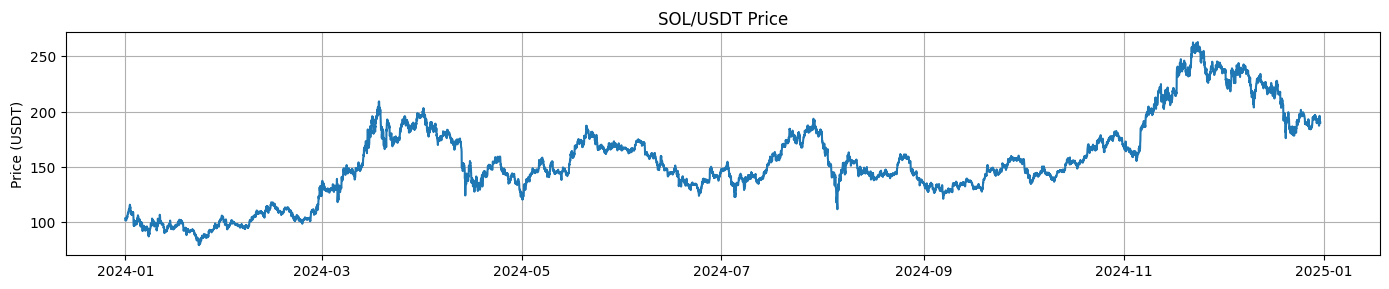

Scarico i dati per DOGE/USDT dal 2024-01-01 al 2024-12-31...


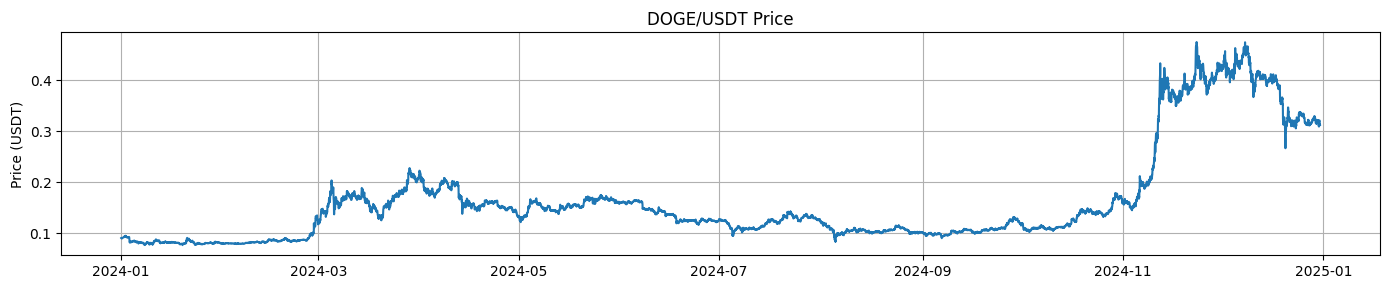

Scarico i dati per LINK/USDT dal 2024-01-01 al 2024-12-31...


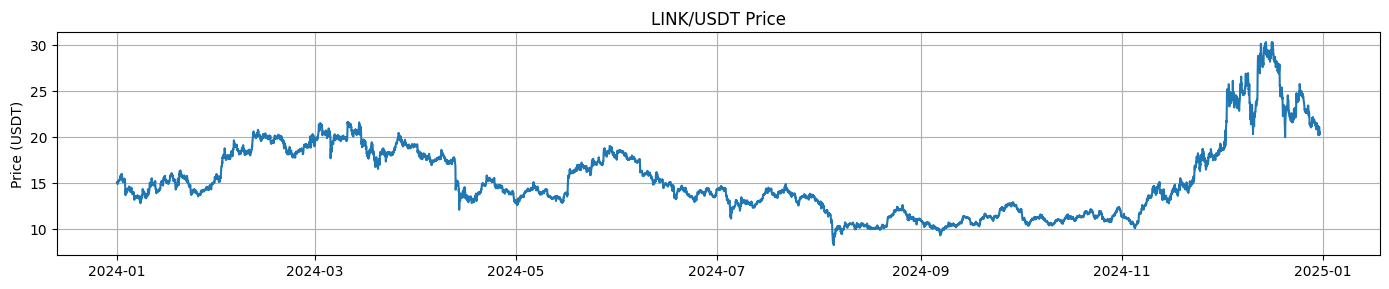

Scarico i dati per SIDUS/USDT dal 2024-01-01 al 2024-12-31...


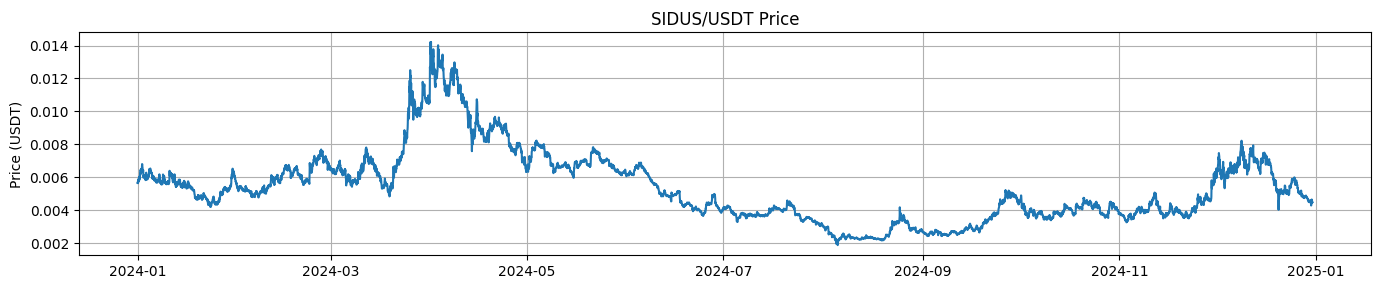

In [15]:
timeframe_download = '1h'  # Specifica il timeframe ('1m', '5m', '1h', '1d', etc.)
start_date = '2024-01-01'  # Data di inizio
end_date = '2024-12-31'  # Data di fine
plot = True
market = 'bybit'

data_frames = download_and_plot(cryptos, market, timeframe_download, start_date, end_date, plot)

In [16]:
crypto_prices = pd.DataFrame()
crypto_prices['timestamp'] = data_frames[cryptos[0]].index
for crypto in cryptos:
    crypto_prices[crypto] = data_frames[crypto]['close'].values
crypto_prices.set_index('timestamp', inplace=True)

# Calcolo del prezzo medio
crypto_prices['mean_price'] = crypto_prices.mean(axis=1)

crypto_prices

,SOL,DOGE,LINK,SIDUS,mean_price
timestamp,,,,,
2024-01-01 00:00:00,101.97,0.08985,15.1174,0.005650,29.295725
2024-01-01 01:00:00,104.11,0.09011,15.1697,0.005699,29.843877
2024-01-01 02:00:00,103.70,0.08979,15.0688,0.005682,29.716068
2024-01-01 03:00:00,103.08,0.08921,14.9246,0.005629,29.524860
2024-01-01 04:00:00,102.61,0.08910,14.9212,0.005691,29.406498
...,...,...,...,...,...
2024-12-30 20:00:00,194.87,0.32087,21.0921,0.004617,54.071897
2024-12-30 21:00:00,189.43,0.31098,20.4280,0.004470,52.543362
2024-12-30 22:00:00,191.17,0.31371,20.5641,0.004493,53.013076


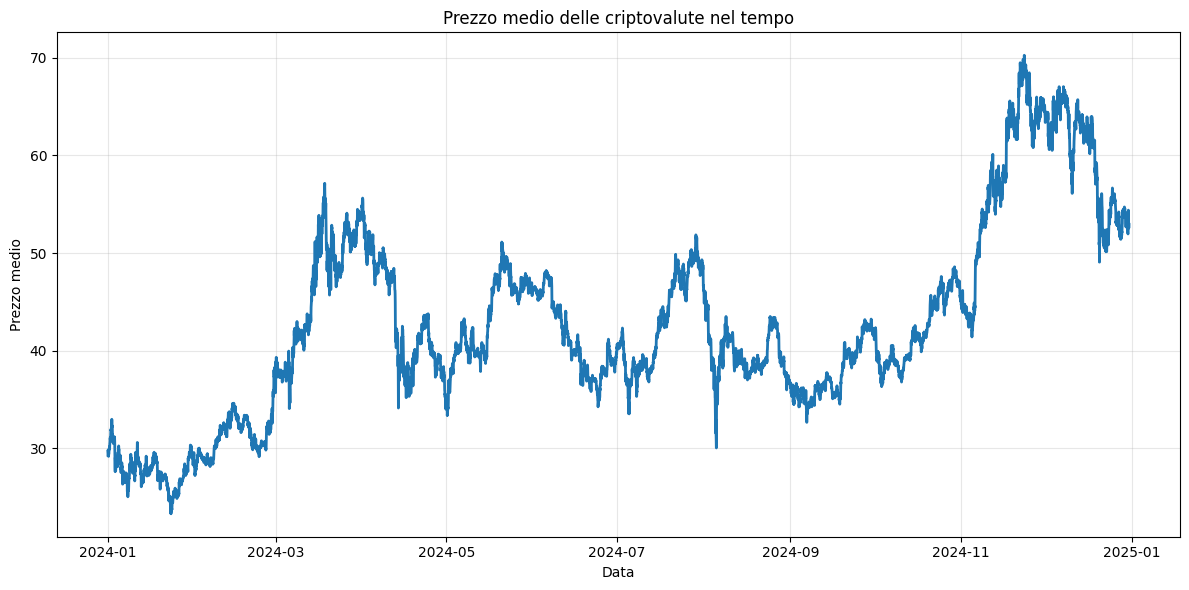

In [17]:
# Creazione del grafico
plt.figure(figsize=(12, 6))
plt.plot(crypto_prices.index, crypto_prices['mean_price'], label='Prezzo Medio', linewidth=2)

# Personalizzazione del grafico
plt.title('Prezzo medio delle criptovalute nel tempo')
plt.xlabel('Data')
plt.ylabel('Prezzo medio')
plt.grid(alpha=0.3)
plt.tight_layout()

# Mostra il grafico
plt.show()

In [2]:
63.88+600.7+15.97+10.65+10.65, 399.98+42.43+157.49+42.43+99.99

(701.85, 742.32)

In [18]:
# crypto_prices.to_csv(f'{list(crypto_prices.columns)}_USDT_timeframe_{timeframe_download}_start_date_{start_date}_end_date_{end_date}.csv')

In [19]:
# crypto_prices = pd.read_csv("['BTC', 'ETH', 'SOL', 'DOGE', 'LINK', 'AXS']_USDT_timeframe_1h_start_date_2021-01-01_end_date_2021-12-31.csv")
# crypto_prices['timestamp'] = pd.to_datetime(crypto_prices['timestamp'])
# crypto_prices.set_index('timestamp', inplace=True)
# crypto_prices

In [20]:
crypto_prices.isna().sum().sum()

0

## Strategia di ribilanciamento

In [30]:
# Parametri fissi
initial_portfolio_value = 100
verbose = True
precision = 0

# Parametri variabili
dynamical_timeframe = 24*3
statical_timeframe = 24
window_allocations = 1
window_portfolio = 1
factor_fall = 1 # Fattore che compare nella function map_variation_to_liquidity_on_fall (se è molto alto significa che voglio avere 100% liquidità)
factor_rise = np.inf # Fattore che compare nella function map_variation_to_liquidity_on_rise (se è molto alto significa che voglio avere 0 liquidità)
dynamical_factors = True
perc_factor_fall = 0.05
perc_factor_rise = 0.05
desired_return = 1000
weighting_factor = 1 # Percentuale di "sfumatura" (solo se precision = 0): 100% significa che viene ruotato tutto sulla crypto migliore del passato, altrimenti più è verso lo 0% e più va in base ai punteggi percentuale di quelle migliori nel passato
risk = False

results_df = simulate_rebalancing_strategy_dynamical(crypto_prices.iloc[:, :-1], initial_allocations, dynamical_timeframe, statical_timeframe, initial_portfolio_value, window_allocations, precision, window_portfolio, verbose, factor_fall, factor_rise, dynamical_factors, perc_factor_fall, perc_factor_rise, desired_return, weighting_factor, risk)

results_df

Miglior allocazione trovata per il giorno 2024-01-04 00:00:00: {'SOL': 0, 'DOGE': 0, 'LINK': 0, 'SIDUS': 1}
Miglior allocazione trovata per il giorno 2024-01-04 00:00:00: {'SOL': 0, 'DOGE': 0, 'LINK': 0, 'SIDUS': 1}
Miglior allocazione trovata per il giorno 2024-01-04 00:00:00: {'SOL': 0, 'DOGE': 0, 'LINK': 0, 'SIDUS': 1}
Miglior allocazione trovata per il giorno 2024-01-04 00:00:00: {'SOL': 0, 'DOGE': 0, 'LINK': 0, 'SIDUS': 1}
Miglior allocazione trovata per il giorno 2024-01-07 00:00:00: {'SOL': 0, 'DOGE': 0, 'LINK': 0, 'SIDUS': 1}
Miglior allocazione trovata per il giorno 2024-01-07 00:00:00: {'SOL': 0, 'DOGE': 0, 'LINK': 0, 'SIDUS': 1}
Miglior allocazione trovata per il giorno 2024-01-07 00:00:00: {'SOL': 0, 'DOGE': 0, 'LINK': 0, 'SIDUS': 1}
Miglior allocazione trovata per il giorno 2024-01-07 00:00:00: {'SOL': 0, 'DOGE': 0, 'LINK': 0, 'SIDUS': 1}
Miglior allocazione trovata per il giorno 2024-01-10 00:00:00: {'SOL': 0, 'DOGE': 0, 'LINK': 0, 'SIDUS': 1}
Miglior allocazione trovata 

,timestamp,liquidità,prezzo_SOL,prezzo_DOGE,prezzo_LINK,prezzo_SIDUS,quantita_SOL,quantita_DOGE,quantita_LINK,quantita_SIDUS,controvalore_SOL,controvalore_DOGE,controvalore_LINK,controvalore_SIDUS,valore_totale_portafoglio
0,2024-01-01 00:00:00,0.0,101.97,0.08985,15.1174,0.005650,0.24517,278.241514,1.653724,4424.700448,25.000000,25.000000,25.000000,25.000000,100.000000
1,2024-01-01 01:00:00,0.0,104.11,0.09011,15.1697,0.005699,0.24517,278.241514,1.653724,4424.700448,25.524664,25.072343,25.086490,25.214598,100.898095
2,2024-01-01 02:00:00,0.0,103.70,0.08979,15.0688,0.005682,0.24517,278.241514,1.653724,4424.700448,25.424144,24.983306,24.919629,25.142033,100.469112
3,2024-01-01 03:00:00,0.0,103.08,0.08921,14.9246,0.005629,0.24517,278.241514,1.653724,4424.700448,25.272139,24.821925,24.681162,24.906639,99.681865
4,2024-01-01 04:00:00,0.0,102.61,0.08910,14.9212,0.005691,0.24517,278.241514,1.653724,4424.700448,25.156909,24.791319,24.675539,25.182740,99.806507
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8756,2024-12-30 20:00:00,0.0,194.87,0.32087,21.0921,0.004617,0.00000,0.000000,0.000000,16506.229947,0.000000,0.000000,0.000000,76.214216,76.214216
8757,2024-12-30 21:00:00,0.0,189.43,0.31098,20.4280,0.004470,0.00000,0.000000,0.000000,16506.229947,0.000000,0.000000,0.000000,73.774595,73.774595
8758,2024-12-30 22:00:00,0.0,191.17,0.31371,20.5641,0.004493,0.00000,0.000000,0.000000,16506.229947,0.000000,0.000000,0.000000,74.164142,74.164142
8759,2024-12-30 23:00:00,0.0,191.38,0.31395,20.5713,0.004477,0.00000,0.000000,0.000000,16506.229947,0.000000,0.000000,0.000000,73.898391,73.898391


In [31]:
fattore_rendimento_totale = results_df['valore_totale_portafoglio'].iloc[-1] / results_df['valore_totale_portafoglio'].iloc[0]
fattore_rendimento_totale

0.7378614910871225

In [32]:
mdp.calcola_principali_metriche(results_df['valore_totale_portafoglio'])

{'Total Return %': -26.21385089128775,
 'Max Drawdown': 86.83846406584283,
 'Volatility': 0.2506267194948714,
 'Sharpe Ratio': 0.08963560881335307,
 'Sortino Ratio': 0.15319691846392966,
 'Calmar Ratio': -0.301869121860698,
 'Profit Factor': 'Non calcolabile: dati insufficienti, servono prezzi e quantità di bitcoin posseduti',
 'PnL': 'Non calcolabile: dati insufficienti, servono prezzi e quantità di bitcoin posseduti'}

In [33]:
max_rendimento_raggiunto = results_df['valore_totale_portafoglio'].max() / results_df['valore_totale_portafoglio'].iloc[0]
max_rendimento_raggiunto

2.338079035811138

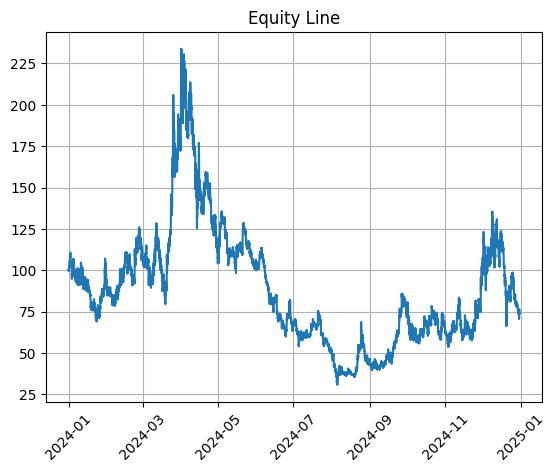

In [34]:
plt.title('Equity Line')
plt.xticks(rotation=45)
plt.grid()
plt.plot(results_df['timestamp'], results_df['valore_totale_portafoglio']);

In [35]:
fattori_df, metriche = calcola_fattori_di_variazione(crypto_prices)

# Stampa dei risultati
print("Fattori di variazione:")
display(fattori_df)

print("\nMetriche (medie delle colonne):")
metriche

Fattori di variazione:


,SOL,DOGE,LINK,SIDUS,mean_price,prodotto_fattori
timestamp,,,,,,
2024-01-01 00:00:00,NaN,NaN,NaN,NaN,NaN,1.000000
2024-01-01 01:00:00,1.020987,1.002894,1.003460,1.008584,1.018711,1.055694
2024-01-01 02:00:00,0.996062,0.996449,0.993349,0.997122,0.995717,0.978875
2024-01-01 03:00:00,0.994021,0.993540,0.990431,0.990637,0.993565,0.962757
2024-01-01 04:00:00,0.995440,0.998767,0.999772,1.011085,0.995991,1.000976
...,...,...,...,...,...,...
2024-12-30 20:00:00,0.993322,1.002813,1.000522,1.004241,0.994034,0.994892
2024-12-30 21:00:00,0.972084,0.969178,0.968514,0.967990,0.971731,0.858282
2024-12-30 22:00:00,1.009185,1.008779,1.006662,1.005280,1.008940,1.039449



Metriche (medie delle colonne):


SOL                 1.000120
DOGE                1.000212
LINK                1.000083
SIDUS               1.000098
mean_price          1.000113
prodotto_fattori    1.001260
dtype: float64

In [38]:
calcola_rendimento_portafoglio_ideale_multicrypto([crypto_prices[crypto] for crypto in initial_allocations.keys()], initial_portfolio_value, [token_iniziali for token_iniziali in initial_allocations.values()], 0, 0, 0, 0)

[6.660376819126452e+34, 8.611582497686581e+36]

## Grid search

In [171]:
# Parametri fissi
initial_allocations = {'BTC': 1/6, 'ETH': 1/6, 'SOL': 1/6, 'DOGE': 1/6, 'LINK': 1/6, 'AXS': 1/6}
initial_portfolio_value = 100
precision = 0
verbose = False
sort_quantity = 'fattore_rendimento_totale'

In [172]:
def grid_search_rebalancing(dati, grid_params, initial_portfolio_value, precision, skip_conditions, sort_quantity):
    """
    Esegue una grid search per ottimizzare i parametri della strategia di ribilanciamento dinamico.

    Parametri:
    - dati: DataFrame con i prezzi delle crypto (righe=giorni, colonne=symbol), con un timestamp.
    - initial_portfolio_value: Valore iniziale del portafoglio in USD.
    - precision: Precisione delle allocazioni (es. 1 per step di 0.1).

    Ritorna:
    - DataFrame con i migliori risultati della grid search ordinati in ordine decrescente per fattore di rendimento totale.
    """

    risultati = []

    # Iterazione nella grid search
    for idx, params in enumerate(grid_params):
        print(f"Inizio iterazione {idx + 1}/{len(grid_params)}")
        print(f"Parametri: {params}")

        if not skip_conditions[idx]:
            # Esegui la strategia
            risultati_df = simulate_rebalancing_strategy_dynamical(
                dati,
                initial_allocations,
                params['dynamical_timeframe'],
                params['statical_timeframe'],
                initial_portfolio_value,
                params['window_allocations'],
                precision,
                params['window_portfolio'],
                verbose,
                params['factor_fall'],
                params['factor_rise'],
                params['dynamical_factors'],
                params['perc_factor_fall'],
                params['perc_factor_rise'],
                params['desired_return'],
                params['weighting_factor'],
                params['risk']
            )

            # Calcola il fattore di rendimento totale
            fattore_rendimento_totale = risultati_df['valore_totale_portafoglio'].iloc[-1] / risultati_df['valore_totale_portafoglio'].iloc[0]
            volatility = mdp.volatility(risultati_df['valore_totale_portafoglio'])
            max_drawdown = mdp.max_drawdown(risultati_df['valore_totale_portafoglio'])
            sharpe_ratio = mdp.sharpe_ratio(risultati_df['valore_totale_portafoglio'])
            sortino_ratio = mdp.sortino_ratio(risultati_df['valore_totale_portafoglio'])
            calmar_ratio = mdp.calmar_ratio(risultati_df['valore_totale_portafoglio'])

            risultati.append({
                **{name: params[name] for name in grid_params[0].keys()},
                'fattore_rendimento_totale': fattore_rendimento_totale,
                'volatility': volatility,
                'max_drawdown': max_drawdown,
                'sharpe_ratio': sharpe_ratio,
                'sortino_ratio': sortino_ratio,
                'calmar_ratio': calmar_ratio
            })

            print(f"Iterazione {idx + 1} completata: Fattore Rendimento Totale = {fattore_rendimento_totale}")

        else:
            print('Salto questa combinazione perchè sarebbe uguale a un\'altra già vista...\n')

    # Ordina i risultati in ordine decrescente per fattore di rendimento totale
    risultati_df = pd.DataFrame(risultati)
    risultati_df = risultati_df.sort_values(by=sort_quantity, ascending=False).reset_index(drop=True)

    print("Grid search completata. Migliori risultati:")

    return risultati_df

In [ ]:
# Dizionario dei parametri per la grid search
param_grid = {
    'dynamical_timeframe': [24*3, 24*7],
    'statical_timeframe': [24, 48, 72],
    'window_allocations': [12, 24, None],
    'window_portfolio': [24, 24*3, None],
    'factor_fall': [0.1, 1, np.inf],
    'factor_rise': [0.1, 1, np.inf],
    'dynamical_factors': [True],
    'perc_factor_fall': [0.05, 0.2],
    'perc_factor_rise': [0.05, 0.2],
    'desired_return': [100, 1000],
    'weighting_factor': [0.75, 1],
    'risk': [True, False]
}

# Genera tutte le combinazioni di parametri
grid_params = list(ParameterGrid(param_grid))

skip_conditions = []

for comb in grid_params:
    condition = comb['window_allocations'] is None and (comb['statical_timeframe'] != param_grid['statical_timeframe'][0] or comb['weighting_factor'] != param_grid['weighting_factor'][0]) or comb['window_portfolio'] is None and (comb['factor_fall'] != param_grid['factor_fall'][0] or comb['factor_rise'] != param_grid['factor_rise'][0]) or not comb['dynamical_factors'] and (comb['perc_factor_fall'] != param_grid['perc_factor_fall'][0] or comb['perc_factor_rise'] != param_grid['perc_factor_rise'][0] or comb['desired_return'] != param_grid['desired_return'][0] or comb['risk'] != param_grid['risk'][0]) or comb['factor_fall'] == np.inf and (comb['perc_factor_fall'] != param_grid['perc_factor_fall'][0] or comb['desired_return'] != param_grid['desired_return'][0] and comb['factor_rise'] == np.inf) or comb['factor_rise'] == np.inf and (comb['perc_factor_rise'] != param_grid['perc_factor_rise'][0] or comb['desired_return'] != param_grid['desired_return'][0] and comb['factor_fall'] == np.inf)
    
    skip_conditions.append(condition)

crypto_list = crypto_prices.columns

risultati_df_ordinati = grid_search_rebalancing(crypto_prices, grid_params, initial_portfolio_value, precision, skip_conditions, sort_quantity)
risultati_df_ordinati

In [ ]:
risultati_df_ordinati[:50]

In [ ]:
risultati_df_ordinati['fattore_rendimento_totale'].mean(), risultati_df_ordinati['fattore_rendimento_totale'].median(), risultati_df_ordinati['fattore_rendimento_totale'].min(), risultati_df_ordinati['fattore_rendimento_totale'].max(), risultati_df_ordinati['fattore_rendimento_totale'].std()

In [ ]:
risultati_df_ordinati.sort_values(by='sharpe_ratio', ascending=False).reset_index(drop=True)

In [ ]:
risultati_df_ordinati.sort_values(by='sortino_ratio', ascending=False).reset_index(drop=True)

In [ ]:
risultati_df_ordinati.sort_values(by='calmar_ratio', ascending=False).reset_index(drop=True)

In [ ]:
risultati_df_ordinati.sort_values(by='max_drawdown', ascending=True).reset_index(drop=True)

# Studio come varia nel tempo l'asset allocation ideale per le crypto scelte

## Ottengo l'elenco delle crypto scaricabili da un certo exchamge

In [158]:
def get_available_cryptos(exchange_name, timeframe, start_date, end_date):
    """
    Ottiene l'elenco delle crypto disponibili in un periodo specificato senza valori NaN.

    Parametri:
    - exchange_name: Nome dell'exchange (es. 'binance').
    - timeframe: Timeframe scelto (es. '1d', '1h').
    - start_date: Data di inizio (stringa 'YYYY-MM-DD').
    - end_date: Data di fine (stringa 'YYYY-MM-DD').

    Ritorna:
    - Lista di simboli crypto disponibili.
    """
    # Inizializza l'exchange CCXT
    exchange = getattr(ccxt, exchange_name)()

    # Converte le date in timestamp UNIX (ms)
    since = int(datetime.strptime(start_date, '%Y-%m-%d').timestamp() * 1000)
    until = int(datetime.strptime(end_date, '%Y-%m-%d').timestamp() * 1000)

    # Ottieni l'elenco dei mercati disponibili
    markets = exchange.load_markets()
    symbols = [market for market in markets.keys()]

    # Lista per salvare le crypto disponibili
    available_cryptos = []

    for symbol in symbols:
        try:
            # Scarica i dati OHLCV
            ohlcv = exchange.fetch_ohlcv(symbol, timeframe, since, limit=None)
            
            # Converte i dati in DataFrame
            df = pd.DataFrame(ohlcv, columns=['timestamp', 'open', 'high', 'low', 'close', 'volume'])
            
            # Filtra per il periodo specificato
            df['timestamp'] = pd.to_datetime(df['timestamp'], unit='ms')
            df = df[(df['timestamp'] >= start_date) & (df['timestamp'] <= end_date)]
            
            # Verifica se ci sono valori NaN
            if not df.isnull().values.any():
                print(f'Trovato il pair {symbol}')
                available_cryptos.append(symbol)
            else:
                print(f'Il pair {symbol} ha dei NaN')
        
        except Exception as e:
            # Ignora gli errori (ad esempio mercati non supportati nel periodo scelto)
            print(f"Errore con il simbolo {symbol}: {e}")

    return available_cryptos

In [159]:
# exchange_name = 'binance'  # Nome dell'exchange
# timeframe = '1d'  # Timeframe (es. '1d' per giornaliero)
# start_date = '2021-01-01'  # Data di inizio
# end_date = '2021-12-31'  # Data di fine

# available_cryptos = get_available_cryptos(exchange_name, timeframe, start_date, end_date)
# print("Crypto disponibili:", available_cryptos)

In [160]:
# len(available_cryptos)

In [161]:
# available_cryptos_usdt = [symbol.split('/USDT')[0] for symbol in available_cryptos if symbol.endswith('/USDT')]
# len(available_cryptos_usdt)

In [162]:
# available_cryptos_usdt

## Fissato un insieme di crypto, un timeframe e un periodo, cerco la miglior AA

In [163]:
def find_best_allocation_with_download(
    chosen_cryptos, 
    timeframe_download,
    timeframe, 
    start_date, 
    end_date, 
    precision, 
    exchange_name='binance'
):
    """
    Trova la miglior asset allocation scaricando i dati delle crypto e massimizzando il rendimento.

    Parametri:
    - chosen_cryptos: Lista delle crypto selezionate.
    - timeframe: Timeframe scelto per il ribilanciamento (ad esempio '1d', '1h').
    - start_date: Data di inizio (formato 'YYYY-MM-DD').
    - end_date: Data di fine (formato 'YYYY-MM-DD').
    - precision: Precisione delle allocazioni (es. 1 significa step di 0.1%).
    - exchange_name: Nome dell'exchange da cui scaricare i dati (default: 'binance').

    Ritorna:
    - Dizionario con la miglior allocazione e il rendimento massimo.
    """
    # Scarica i dati con la tua funzione `download_and_plot`
    data_frames = download_and_plot(chosen_cryptos, timeframe_download, start_date, end_date, plot=False)

    # Prepara il DataFrame `crypto_prices` con timestamp e prezzi di chiusura
    crypto_prices = pd.DataFrame()
    crypto_prices['timestamp'] = data_frames[chosen_cryptos[0]].index
    for crypto in chosen_cryptos:
        # print(crypto)
        # display(data_frames[crypto]['close'].values)
        crypto_prices[crypto] = data_frames[crypto]['close'].values
    crypto_prices.set_index('timestamp', inplace=True)

    # Filtra il DataFrame per il periodo specificato
    dati_periodo = crypto_prices[
        (crypto_prices.index >= pd.Timestamp(start_date)) & 
        (crypto_prices.index <= pd.Timestamp(end_date))
    ]

    # Genera tutte le possibili combinazioni di allocazioni
    allocations = generate_allocations(chosen_cryptos, precision)

    best_allocation = None
    best_return = -np.inf

    # Valore iniziale del portafoglio
    initial_portfolio_value = 100

    # Simula ogni allocazione e trova la migliore
    for allocation in allocations:
        # Simula la strategia di ribilanciamento per l'allocazione corrente
        risultati_df = simulate_rebalancing_strategy_dynamical(crypto_prices, initial_allocations, dynamical_timeframe, statical_timeframe, initial_portfolio_value, window_allocations, precision, window_portfolio, verbose, factor_fall, factor_rise)

        # Calcola il rendimento totale
        rendimento = risultati_df['valore_totale_portafoglio'].iloc[-1] / risultati_df['valore_totale_portafoglio'].iloc[0]
        print(f'Asset Allocation: {allocation} -> Rendimento: {rendimento}')

        # Aggiorna la miglior allocazione se necessario
        if rendimento > best_return:
            best_return = rendimento
            best_allocation = allocation

    return {'allocazione': best_allocation, 'rendimento': best_return}

In [ ]:
# Esempio di utilizzo
chosen_cryptos = ['BTC', 'ETH', 'LINK', 'DOGE']  # Le crypto da analizzare
timeframe_download = '1d'
timeframe = 7  # Ribilanciamento settimanale
start_date = '2021-01-01'
end_date = '2021-12-31'
precision = 0  # Precisione delle allocazioni (ad esempio 1 decimale)

# Trova la miglior asset allocation
result = find_best_allocation_with_download(chosen_cryptos, timeframe_download, timeframe, start_date, end_date, precision)
print("Miglior allocazione:", result['allocazione'])
print("Rendimento massimo:", result['rendimento'])

## Variazione nel tempo della miglior asset allocation in un periodo mobile di period_length giorni

In [166]:
def analyze_allocation_over_periods(
    chosen_cryptos, 
    timeframe_download, 
    timeframe_rebalance, 
    start_date, 
    end_date, 
    precision, 
    period_length
):
    """
    Analizza come varia l'asset allocation ideale su periodi di `period_length` giorni.

    Parametri:
    - chosen_cryptos: Lista delle crypto scelte.
    - timeframe_download: Timeframe per scaricare i dati (es. '1d').
    - timeframe_rebalance: Timeframe di ribilanciamento (numero di giorni).
    - start_date: Data di inizio dell'analisi.
    - end_date: Data di fine dell'analisi.
    - precision: Precisione delle allocazioni (es. 1 significa step di 0.1%).
    - period_length: Lunghezza di ciascun periodo in giorni.

    Ritorna:
    - Lista di dizionari con la miglior allocazione per ciascun periodo.
    """
    # Scarica i dati una volta per tutte
    data_frames = download_and_plot(chosen_cryptos, timeframe_download, start_date, end_date, plot=False)

    # Prepara il DataFrame `crypto_prices`
    crypto_prices = pd.DataFrame()
    crypto_prices['timestamp'] = data_frames[chosen_cryptos[0]].index
    for crypto in chosen_cryptos:
        crypto_prices[crypto] = data_frames[crypto]['close'].values
    crypto_prices.set_index('timestamp', inplace=True)

    # Calcola tutti i sottoperiodi
    timestamps = pd.date_range(start=pd.Timestamp(start_date), end=pd.Timestamp(end_date), freq='1D')
    periods = [
        (timestamps[i], timestamps[i + period_length - 1]) 
        for i in range(len(timestamps) - period_length + 1)
    ]

    # Lista per salvare i risultati
    results = []

    # Analizza ogni sottoperiodo
    for start, end in periods:
        print(f"Analizzando il periodo da {start.date()} a {end.date()}...")
        try:
            result = find_best_allocation_with_download(
                chosen_cryptos, timeframe_download, timeframe_rebalance, start.date(), end.date(), precision
            )
            print(f"Miglior allocazione per il periodo dal {start.date()} al {end.date()}:", result['allocazione'])
            print(f"Rendimento massimo per il periodo dal {start.date()} al {end.date()}:", result['rendimento'])
            results.append({
                'period_start': start,
                'period_end': end,
                'best_allocation': result['allocazione'],
                'max_return': result['rendimento']
            })
        except Exception as e:
            print(f"Errore nel periodo {start.date()} - {end.date()}: {e}")
            results.append({
                'period_start': start,
                'period_end': end,
                'best_allocation': None,
                'max_return': None
            })

    return pd.DataFrame(results)

In [ ]:
# Esempio di utilizzo
chosen_cryptos = ['BTC', 'ETH', 'LINK', 'DOGE']  # Le crypto da analizzare
timeframe_download = '1d'  # Timeframe per scaricare i dati
timeframe_rebalance = 7  # Ribilanciamento settimanale
start_date = '2021-01-01'
end_date = '2021-12-31'
precision = 0  # Precisione delle allocazioni (ad esempio 1 decimale)
period_length = 30  # Lunghezza dei periodi in giorni

# Analizza come varia l'asset allocation nel tempo
results_df = analyze_allocation_over_periods(
    chosen_cryptos, 
    timeframe_download, 
    timeframe_rebalance, 
    start_date, 
    end_date, 
    precision, 
    period_length
)

results_df

In [ ]:
# Estrai le allocazioni per ciascuna crypto
allocations_df = results_df.dropna().copy()
for crypto in chosen_cryptos:
    allocations_df[crypto] = allocations_df['best_allocation'].apply(lambda x: x.get(crypto, 0) if x else 0)

# Grafico delle allocazioni
plt.figure(figsize=(14, 8))
for crypto in chosen_cryptos:
    # if crypto == 'BTC':
        plt.plot(allocations_df['period_start'], allocations_df[crypto], label=crypto)

plt.title('Variazione dell\'asset allocation ideale nel tempo')
plt.xlabel('Periodo di inizio')
plt.ylabel('Percentuale Allocata')
plt.legend()
plt.grid()
plt.show()

In [ ]:
allocations_df

In [ ]:
allocations_df[allocations_df['max_return'] == allocations_df['max_return'].max()]

In [ ]:
# Calcola la media e la deviazione standard delle allocazioni per ciascuna crypto
allocation_stats = allocations_df[chosen_cryptos].describe()
allocation_stats

In [ ]:
# Calcola i rendimenti medi e la volatilità per ciascun periodo
allocations_df['avg_return'] = allocations_df.apply(
    lambda row: crypto_prices.loc[row['period_start']:row['period_end']].pct_change().mean().mean(), axis=1
)
allocations_df['volatility'] = allocations_df.apply(
    lambda row: crypto_prices.loc[row['period_start']:row['period_end']].pct_change().std().mean(), axis=1
)

# Grafico della correlazione tra allocazioni e volatilità/rendimenti
plt.figure(figsize=(14, 8))
for crypto in chosen_cryptos:
    plt.scatter(allocations_df['avg_return'], allocations_df[crypto], label=crypto)
plt.title('Allocazioni vs. Rendimenti')
plt.xlabel('Rendimenti Medi')
plt.ylabel('Percentuale Allocata')
plt.legend()
plt.grid()
plt.show()

plt.figure(figsize=(14, 8))
for crypto in chosen_cryptos:
    plt.scatter(allocations_df['volatility'], allocations_df[crypto], label=crypto)
plt.title('Allocazioni vs. Volatilità')
plt.xlabel('Volatilità')
plt.ylabel('Percentuale Allocata')
plt.legend()
plt.grid()
plt.show()

In [174]:
# from sklearn.cluster import KMeans
# from sklearn.preprocessing import StandardScaler

# # Normalizza i dati delle allocazioni
# scaler = StandardScaler()
# allocations_normalized = scaler.fit_transform(allocations_df[chosen_cryptos])

# # Applica K-Means
# kmeans = KMeans(n_clusters=3, random_state=42)  # Modifica `n_clusters` in base al problema
# allocations_df['cluster'] = kmeans.fit_predict(allocations_normalized)

# # Grafico dei cluster
# plt.figure(figsize=(14, 8))
# for crypto in chosen_cryptos:
#     plt.scatter(allocations_df['period_start'], allocations_df[crypto], c=allocations_df['cluster'], cmap='viridis', label=crypto)
# plt.title('Cluster delle Allocazioni Ideali nel Tempo')
# plt.xlabel('Periodo di Inizio')
# plt.ylabel('Percentuale Allocata')
# plt.colorbar(label='Cluster')
# plt.grid()
# plt.show()

In [ ]:
# Trova periodi con allocazioni estreme
extreme_allocations = allocations_df[allocations_df[chosen_cryptos].max(axis=1) > 0.8]
print("Periodi con allocazioni estreme:")
print(extreme_allocations[['period_start', 'period_end', 'best_allocation']])

In [ ]:
plt.figure(figsize=(14, 8))
sns.heatmap(
    allocations_df[chosen_cryptos].T, 
    cmap="YlGnBu", 
    xticklabels=allocations_df['period_start'].dt.strftime('%Y-%m-%d'),
    cbar_kws={'label': 'Percentuale Allocata'}
)
plt.title('Allocazioni Ideali nel Tempo (Heatmap)')
plt.xlabel('Periodo di Inizio')
plt.ylabel('Crypto')
plt.xticks(rotation=45)
plt.show()

In [ ]:
from scipy.fft import fft, fftfreq

# Applica la trasformata di Fourier a ciascuna crypto
periods = []
for crypto in chosen_cryptos:
    fft_vals = fft(allocations_df[crypto])
    fft_freq = fftfreq(len(allocations_df), d=1)  # d=1 perché ogni riga rappresenta un periodo
    periods.append(1 / fft_freq[np.argmax(np.abs(fft_vals[1:]))])  # Escludi il componente DC

# Stampa i periodi principali
for crypto, period in zip(chosen_cryptos, periods):
    print(f"Periodo principale per {crypto}: {period:.2f} periodi")